In [ ]:
import pandas as pd 
import numpy as np

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from PIL import Image
import cv2
from tensorflow.keras.preprocessing import image as kimage
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [21]:
image_list = []
labels = []
Class=os.listdir("dataset")

for i in ["with_mask","without_mask"]:
    path = "dataset/{}/".format(i)
    Class=os.listdir(path)
    for a in Class:
        image=cv2.imread(path+a)
        
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        image = preprocess_input(np.array(size_image))
        
        image_list.append(np.array(image))
        labels.append(i)

In [22]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [23]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(np.array(image_list), 
                                                  np.array(labels), test_size=0.20, stratify=labels, random_state=42)

In [25]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

c:\users\loren\anaconda3\envs\tensorflowgpu\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [26]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [27]:
for layer in baseModel.layers:
    layer.trainable = False


In [29]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])


H = model.fit(aug.flow(trainX, trainY, batch_size=BS),steps_per_epoch=len(trainX) // BS,
              validation_data=(testX, testY),
            validation_steps=len(testX) // BS,
              epochs=10)

  ...
    to  
  ['...']
Train for 34 steps, validate on 276 samples
Epoch 1/10
34/34 [==============================] - 11s 325ms/step - loss: 0.0504 - accuracy: 0.9822 - val_loss: 0.0368 - val_accuracy: 0.9805
Epoch 2/10
34/34 [==============================] - 8s 245ms/step - loss: 0.0399 - accuracy: 0.9841 - val_loss: 0.0369 - val_accuracy: 0.9922
Epoch 3/10
34/34 [==============================] - 8s 241ms/step - loss: 0.0364 - accuracy: 0.9860 - val_loss: 0.0362 - val_accuracy: 0.9805
Epoch 4/10
34/34 [==============================] - 8s 244ms/step - loss: 0.0413 - accuracy: 0.9860 - val_loss: 0.0428 - val_accuracy: 0.9883
Epoch 5/10
34/34 [==============================] - 8s 244ms/step - loss: 0.0529 - accuracy: 0.9766 - val_loss: 0.0366 - val_accuracy: 0.9922
Epoch 6/10
34/34 [==============================] - 8s 249ms/step - loss: 0.0483 - accuracy: 0.9841 - val_loss: 0.0302 - val_accuracy: 0.9883
Epoch 7/10
34/34 [==============================] - 8s 248ms/step - loss: 0.03

In [31]:
model.save("model_face.h5")
model.save_weights("model_face_weights.h5")

In [40]:
model.predict(np.expand_dims(trainX[1], axis=0)).argmax(axis = -1)

array([0], dtype=int64)

In [38]:
np.expand_dims(trainX[1], axis=0).shape

(1, 224, 224, 3)

In [53]:
trainY.argmax(axis = -1)

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [55]:
trainY[-1]

array([0., 1.], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


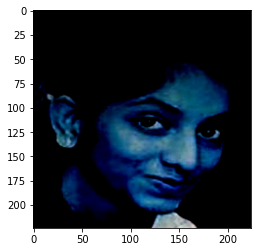

In [59]:
plt.imshow(trainX[-1])

In [57]:
trainX[1].shape

(224, 224, 3)

In [ ]:
# 0 con maschera 1 senza